In [7]:
#======================================================================
#
#     This routine solves an infinite horizon growth model 
#     with dynamic programming and sparse grids
#
#     The model is described in Scheidegger & Bilionis (2017)
#     https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400
#
#     external libraries needed:
#     - IPOPT (https://projects.coin-or.org/Ipopt)
#     - PYIPOPT (https://github.com/xuy/pyipopt)
#     - TASMANIAN (http://tasmanian.ornl.gov/)
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#import nonlinear_solver_initial as solver     #solves opt. problems for terminal VF
#import nonlinear_solver_iterate as solviter   #solves opt. problems during VFI
#import nonlinear_solver_iterate as solveriter   #solves opt. problems during VFI
#from parameters import *                      #parameters of model
#import interpolation as interpol              #interface to sparse grid library/terminal VF
#import interpolation_iter as interpol_iter    #interface to sparse grid library/iteration
import postprocessing as post                 #computes the L2 and Linfinity error of the model

import TasmanianSG                            #sparse grid library
import numpy as np
#======================================================================

In [8]:
#======================================================================
# 
#     sets the parameters for the model
#     "Growth Model"
#
#     The model is described in Scheidegger & Bilionis (2017)
#     https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400
#
#     Simon Scheidegger, 11/16 ; 07/17
#====================================================================== 

#import numpy as np

#====================================================================== 

# Depth of "Classical" Sparse grid
iDepth=1
iOut=1         # how many outputs
which_basis = 1 #linear basis function (2: quadratic local basis)

# control of iterations
numstart = 0   # which is iteration to start (numstart = 0: start from scratch, number=/0: restart)
numits = 3    # which is the iteration to end

refinement_level = 3 #NEW
fTol = 1.E-5 #NEW

# How many random points for computing the errors
No_samples = 1000

#====================================================================== 

# Model Paramters

states = np.array([.9, .95, 1, 1.05, 1.10]) ## added zz stochastics
num_states = len(states[:])
#print(num_states)

n_agents=2  # number of continuous dimensions of the model

beta=0.8
rho=0.95
zeta=0.5
psi=0.36
gamma=2.0
delta=0.025
eta=1
big_A=(1.0-beta)/(psi*beta)

# Ranges For States
range_cube=1 # range of [0..1]^d in 1D
k_bar=0.2
k_up=3.0

# Ranges for Controls
c_bar=1e-2
c_up=10000.0

l_bar=1e-2
l_up=1.0

inv_bar=1e-2
inv_up=10000.0

#====================================================================== 

In [9]:
#======================================================================
# 
#     sets the economic functions for the "Growth Model", i.e., 
#     the production function, the utility function
#     
#
#     Simon Scheidegger, 11/16 ; 07/17
#====================================================================== 

#from parameters import *
#import numpy as np

#====================================================================== 
#utility function u(c,l) 

def utility(cons=[], lab=[]):
    sum_util=0.0
    n=len(cons)
    for i in range(n):
        nom1=(cons[i]/big_A)**(1.0-gamma) -1.0
        den1=1.0-gamma
        
        nom2=(1.0-psi)*((lab[i]**(1.0+eta)) -1.0)
        den2=1.0+eta
        
        sum_util+=(nom1/den1 - nom2/den2)
    
    util=sum_util
    
    return util 


#====================================================================== 
# output_f 

#def output_f(kap=[], lab=[]):
#    fun_val = big_A*(kap**psi)*(lab**(1.0 - psi))
#    return fun_val

def output_f(zz, kap=[], lab=[]): ## added zz stochastics
    fun_val = states[zz] * big_A*(kap**psi)*(lab**(1.0 - psi)) ## added zz stochastics
    return fun_val

#======================================================================

In [10]:
#=======================================================================
#
#     ipopt_wrapper.py : an interface to IPOPT and PYIPOPT 
#
#     Simon Scheidegger, 06/17
#
#=======================================================================

#from parameters import *
#from econ import *
#import numpy as np

#=======================================================================
#   Objective Function to start VFI (in our case, the value function)
        
def EV_F(X, k_init, n_agents, zz): ## added zz stochastics
    
    # Extract Variables
    cons=X[0:n_agents]
    lab=X[n_agents:2*n_agents]
    inv=X[2*n_agents:3*n_agents]
    
    knext= (1-delta)*k_init + inv
    # Compute Value Function
    
    VT_sum=utility(cons, lab) + beta*V_INFINITY(zz, knext) ## added zz stochastics
       
    return VT_sum

# V infinity
def V_INFINITY(zz, k=[]): ## added zz stochastics
    e=np.ones(len(k))
    c=output_f(zz,k,e) ## added zz stochastics
    v_infinity=utility(c,e)/(1-beta)
    return v_infinity

#=======================================================================
#   Objective Function during VFI (note - we need to interpolate on an "old" sprase grid)
    
def EV_F_ITER(X, k_init, n_agents, grid): 
    
    # Extract Variables
    cons=X[0:n_agents]
    lab=X[n_agents:2*n_agents]
    inv=X[2*n_agents:3*n_agents]
    
    knext= (1-delta)*k_init + inv
    
    # Compute Value Function
    
    VT_sum=utility(cons, lab) + beta*grid.evaluate(knext)
       
    return VT_sum
    
#=======================================================================
#   Computation of gradient (first order finite difference) of initial objective function 

def EV_GRAD_F(X, k_init, n_agents, zz): ## added zz stochastics
    
    N=len(X)
    GRAD=np.zeros(N, float) # Initial Gradient of Objective Function
    h=1e-4
    
    
    for ixN in range(N):
        xAdj=np.copy(X)
        
        if (xAdj[ixN] - h >= 0):
            xAdj[ixN]=X[ixN] + h            
            fx2=EV_F(xAdj, k_init, n_agents, zz) ## added zz stochastics
            
            xAdj[ixN]=X[ixN] - h
            fx1=EV_F(xAdj, k_init, n_agents, zz) ## added zz stochastics
            
            GRAD[ixN]=(fx2-fx1)/(2.0*h)
            
        else:
            xAdj[ixN]=X[ixN] + h 
            fx2=EV_F(xAdj, k_init, n_agents, zz) ## added zz stochastics
            
            xAdj[ixN]=X[ixN]
            fx1=EV_F(xAdj, k_init, n_agents, zz) ## added zz stochastics
            GRAD[ixN]=(fx2-fx1)/h
            
    return GRAD
    
#=======================================================================
#   Computation of gradient (first order finite difference) of the objective function 
    
def EV_GRAD_F_ITER(X, k_init, n_agents, grid):
    
    N=len(X)
    GRAD=np.zeros(N, float) # Initial Gradient of Objective Function
    h=1e-4
    
    
    for ixN in range(N):
        xAdj=np.copy(X)
        
        if (xAdj[ixN] - h >= 0):
            xAdj[ixN]=X[ixN] + h            
            fx2=EV_F_ITER(xAdj, k_init, n_agents, grid)
            
            xAdj[ixN]=X[ixN] - h
            fx1=EV_F_ITER(xAdj, k_init, n_agents, grid)
            
            GRAD[ixN]=(fx2-fx1)/(2.0*h)
            
        else:
            xAdj[ixN]=X[ixN] + h
            fx2=EV_F_ITER(xAdj, k_init, n_agents, grid)
            
            xAdj[ixN]=X[ixN]
            fx1=EV_F_ITER(xAdj, k_init, n_agents, grid)
            GRAD[ixN]=(fx2-fx1)/h
            
    return GRAD
       
#======================================================================
#   Equality constraints for the first time step of the model
            
def EV_G(X, k_init, n_agents, zz): ## added zz stochastics
    N=len(X)
    M=3*n_agents+1  # number of constraints
    G=np.empty(M, float)
    
    # Extract Variables
    cons=X[:n_agents]
    lab=X[n_agents:2*n_agents]
    inv=X[2*n_agents:3*n_agents]
    
    
    # first n_agents equality constraints
    for i in range(n_agents):
        G[i]=cons[i]
        G[i + n_agents]=lab[i]
        G[i+2*n_agents]=inv[i]
    
    
    f_prod=output_f(zz, k_init, lab) ## added zz stochastics
    Gamma_adjust=0.5*zeta*k_init*((inv/k_init - delta)**2.0)
    sectors_sum=cons + inv - delta*k_init - (f_prod - Gamma_adjust)
    G[3*n_agents]=np.sum(sectors_sum)
    
    return G
    
#======================================================================
#   Equality constraints during the VFI of the model

def EV_G_ITER(X, k_init, n_agents, zz): ## added zz stochastics
    N=len(X)
    M=3*n_agents+1  # number of constraints
    G=np.empty(M, float)
    
    # Extract Variables
    cons=X[:n_agents]
    lab=X[n_agents:2*n_agents]
    inv=X[2*n_agents:3*n_agents]
    
    
    # first n_agents equality constraints
    for i in range(n_agents):
        G[i]=cons[i]
        G[i + n_agents]=lab[i]
        G[i+2*n_agents]=inv[i]
    
    
    f_prod=output_f(zz, k_init, lab) ## added zz stochastics
    Gamma_adjust=0.5*zeta*k_init*((inv/k_init - delta)**2.0)
    sectors_sum=cons + inv - delta*k_init - (f_prod - Gamma_adjust)
    G[3*n_agents]=np.sum(sectors_sum)
    
    return G

#======================================================================
#   Computation (finite difference) of Jacobian of equality constraints 
#   for first time step
    
def EV_JAC_G(X, flag, k_init, n_agents, zz): ## added zz stochastics
    N=len(X)
    M=3*n_agents+1
    NZ=M*N
    A=np.empty(NZ, float)
    ACON=np.empty(NZ, int)
    AVAR=np.empty(NZ, int)    
    
    # Jacobian matrix structure
    
    if (flag):
        for ixM in range(M):
            for ixN in range(N):
                ACON[ixN + (ixM)*N]=ixM
                AVAR[ixN + (ixM)*N]=ixN
                
        return (ACON, AVAR)
        
    else:
        # Finite Differences
        h=1e-4
        gx1=EV_G(X, k_init, n_agents, zz) ## added zz stochastics
        
        for ixM in range(M):
            for ixN in range(N):
                xAdj=np.copy(X)
                xAdj[ixN]=xAdj[ixN]+h
                gx2=EV_G(xAdj, k_init, n_agents, zz) ## added zz stochastics
                A[ixN + ixM*N]=(gx2[ixM] - gx1[ixM])/h
        return A

#======================================================================
#   Computation (finite difference) of Jacobian of equality constraints 
#   during iteration  
  
def EV_JAC_G_ITER(X, flag, k_init, n_agents, zz): ## added zz stochastics
    N=len(X)
    M=3*n_agents+1
    NZ=M*N
    A=np.empty(NZ, float)
    ACON=np.empty(NZ, int)
    AVAR=np.empty(NZ, int)    
    
    # Jacobian matrix structure
    
    if (flag):
        for ixM in range(M):
            for ixN in range(N):
                ACON[ixN + (ixM)*N]=ixM
                AVAR[ixN + (ixM)*N]=ixN
                
        return (ACON, AVAR)
        
    else:
        # Finite Differences
        h=1e-4
        gx1=EV_G_ITER(X, k_init, n_agents, zz) ## added zz stochastics
        
        for ixM in range(M):
            for ixN in range(N):
                xAdj=np.copy(X)
                xAdj[ixN]=xAdj[ixN]+h
                gx2=EV_G_ITER(xAdj, k_init, n_agents, zz) ## added zz stochastics
                A[ixN + ixM*N]=(gx2[ixM] - gx1[ixM])/h
        return A    
    
#======================================================================

In [11]:
#======================================================================
#
#     This routine interfaces with IPOPT
#     It sets the optimization problem for every gridpoint
#     at the beginning of the VFI.
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#from parameters import *
#from ipopt_wrapper import EV_F, EV_GRAD_F, EV_G, EV_JAC_G
#import numpy as np
import pyipopt

#======================================================================

def initial(k_init, n_agents, zz): ## added zz stochastics
    # IPOPT PARAMETERS below 
    nvars=3*n_agents
    N=nvars         # number of vars
    M=3*n_agents+1  # number of constraints
    NELE_JAC=N*M
    NELE_HESS=(N**2-N)/2 + N    # number of non-zero entries of Hess matrix

    # check that number of nonlinear equations is consistent 
    if (N!=3*n_agents):
        print("there is an error with the number of non-lin eqs!")
        quit

    # Vector of variables -> solution of non-linear equation system 
    X=np.empty(N)

    LAM=np.empty(M) # multipliers
    G=np.empty(M)   # (in-)equality constraints

    # Vector of lower and upper bounds
    G_L=np.empty(M)
    G_U=np.empty(M)

    X_L=np.empty(N)
    X_U=np.empty(N)

    Z_L=np.empty(N)
    Z_U=np.empty(N)

    # get coords of an individual grid points 
    grid_pt_box=k_init
    X_L[:n_agents]=c_bar
    X_U[:n_agents]=c_up

    X_L[n_agents:2*n_agents]=l_bar
    X_U[n_agents:2*n_agents]=l_up

    X_L[2*n_agents:3*n_agents]=inv_bar
    X_U[2*n_agents:3*n_agents]=inv_up

    # Set bounds for the constraints 
    G_L[:n_agents]=c_bar
    G_U[:n_agents]=c_up

    G_L[n_agents:2*n_agents]=l_bar
    G_U[n_agents:2*n_agents]=l_up

    G_L[2*n_agents:3*n_agents]=inv_bar
    G_U[2*n_agents:3*n_agents]=inv_up

    G_L[3*n_agents]=0.0 # both values set to 0 for equality contraints
    G_U[3*n_agents]=0.0

    # initial guesses for first iteration
    cons_init=0.5*(X_U[:n_agents] - X_L[:n_agents]) + X_L[:n_agents]
    lab_init=0.5*(X_U[n_agents:2*n_agents] - X_L[n_agents:2*n_agents]) + X_L[n_agents:2*n_agents]
    inv_init=0.5*(X_U[2*n_agents:3*n_agents] - X_L[2*n_agents:3*n_agents]) + X_L[2*n_agents:3*n_agents]

    X[:n_agents]=cons_init
    X[n_agents:2*n_agents]=lab_init
    X[2*n_agents:3*n_agents]=inv_init
    #X=np.ones(nvars)
    
    # Create ev_f, eval_f, eval_grad_f, eval_g, eval_jac_g for given k_init and n_agent 
    def eval_f(X):
        return EV_F(X, k_init, n_agents, zz) ## added zz stochastics
    
    def eval_grad_f(X):
        return EV_GRAD_F(X,k_init, n_agents, zz) ## added zz stochastics
    
    def eval_g(X):
        return EV_G(X, k_init, n_agents, zz) ## added zz stochastics
        
    def eval_jac_g(X, flag):
        return EV_JAC_G(X, flag, k_init, n_agents, zz) ## added zz stochastics
        
    # First create a handle for the Ipopt problem 
    nlp=pyipopt.create(nvars, X_L, X_U, M, G_L, G_U, NELE_JAC, NELE_HESS, eval_f, eval_grad_f, eval_g, eval_jac_g)
    nlp.num_option("obj_scaling_factor", -1.00)
    nlp.num_option("tol", 1e-6)
    nlp.num_option("acceptable_tol", 1e-5)
    nlp.str_option("derivative_test", "first-order")
    nlp.str_option("hessian_approximation", "limited-memory")
    nlp.int_option("print_level", 0)
    
    x, z_l, z_u, constraint_multipliers, obj, status=nlp.solve(X)
    nlp.close()

    # Unpack Consumption, Labor, and Investment 
    c=x[:n_agents]
    l=x[n_agents:2*n_agents]
    inv=x[2*n_agents:3*n_agents]
    
    to_print=np.hstack((obj,x))
    
    return obj, c, l, inv
    

In [12]:
#======================================================================
#
#     This routine interfaces with IPOPT
#     It sets the optimization problem for every gridpoint
#     during the VFI.
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#from parameters import *
#import TasmanianSG
#from ipopt_wrapper import EV_F_ITER, EV_GRAD_F_ITER, EV_G_ITER, EV_JAC_G_ITER
#import numpy as np
import pyipopt

def iterate(k_init, n_agents, grid, zz): ## added zz stochastics
    
    # IPOPT PARAMETERS below "
    N=3*n_agents    # number of vars
    M=3*n_agents+1  # number of constraints
    NELE_JAC=N*M
    NELE_HESS=(N**2-N)/2 + N    # number of non-zero entries of Hess matrix
    
    # Vector of variables -> solution of non-linear equation system 
    X=np.empty(N)

    LAM=np.empty(M) # multipliers
    G=np.empty(M)   # (in-)equality constraints

    # Vector of lower and upper bounds
    G_L=np.empty(M)
    G_U=np.empty(M)

    X_L=np.empty(N)
    X_U=np.empty(N)

    Z_L=np.empty(N)
    Z_U=np.empty(N)

    # get coords of an individual grid points 
    grid_pt_box=k_init
    X_L[:n_agents]=c_bar
    X_U[:n_agents]=c_up

    X_L[n_agents:2*n_agents]=l_bar
    X_U[n_agents:2*n_agents]=l_up

    X_L[2*n_agents:3*n_agents]=inv_bar
    X_U[2*n_agents:3*n_agents]=inv_up

    # Set bounds for the constraints 
    G_L[:n_agents]=c_bar
    G_U[:n_agents]=c_up

    G_L[n_agents:2*n_agents]=l_bar
    G_U[n_agents:2*n_agents]=l_up

    G_L[2*n_agents:3*n_agents]=inv_bar
    G_U[2*n_agents:3*n_agents]=inv_up

    G_L[3*n_agents]=0.0 # both values set to 0 for equality contraints
    G_U[3*n_agents]=0.0

    # initial guesses for first iteration
    cons_init=0.5*(X_U[:n_agents] - X_L[:n_agents]) + X_L[:n_agents]
    lab_init=0.5*(X_U[n_agents:2*n_agents] - X_L[n_agents:2*n_agents]) + X_L[n_agents:2*n_agents]
    inv_init=0.5*(X_U[2*n_agents:3*n_agents] - X_L[2*n_agents:3*n_agents]) + X_L[2*n_agents:3*n_agents]

    X[:n_agents]=cons_init
    X[n_agents:2*n_agents]=lab_init
    X[2*n_agents:3*n_agents]=inv_init
    
    # Create ev_f, eval_f, eval_grad_f, eval_g, eval_jac_g for given k_init and n_agent 
        
    def eval_f(X):
        return EV_F_ITER(X, k_init, n_agents, grid)
        
    def eval_grad_f(x):
        return EV_GRAD_F_ITER(X, k_init, n_agents, grid)
        
    def eval_g(x):
        return EV_G_ITER(X, k_init, n_agents, zz) ## added zz stochastics
        
    def eval_jac_g(x, flag):
        return EV_JAC_G_ITER(X, flag, k_init, n_agents, zz) ## added zz stochastics
        
    # First create a handle for the Ipopt problem 
    nlp=pyipopt.create(N, X_L, X_U, M, G_L, G_U, NELE_JAC, NELE_HESS, eval_f, eval_grad_f, eval_g, eval_jac_g)
    nlp.num_option("obj_scaling_factor", -1.00)
    nlp.num_option("tol", 1e-6)
    nlp.num_option("acceptable_tol", 1e-5)
    nlp.str_option("derivative_test", "first-order")
    nlp.str_option("hessian_approximation", "limited-memory")
    nlp.int_option("print_level", 0)
    
    x, z_l, z_u, constraint_multipliers, obj, status=nlp.solve(X)
    nlp.close()
    # x: Solution of the primal variables
    # z_l, z_u: Solution of the bound multipliers
    # constraint_multipliers: Solution of the constraint multipliers
    # obj: Objective value
    # status: Exit Status

    # Unpack Consumption, Labor, and Investment
    c=x[:n_agents]
    l=x[n_agents:2*n_agents]
    inv=x[2*n_agents:3*n_agents]
    to_print=np.hstack((obj,x))
    
    # === debug
    #f=open("results.txt", 'a')
    #np.savetxt(f, np.transpose(to_print) #, fmt=len(x)*'%10.10f ')
    #for num in to_print:
    #    f.write(str(num)+"\t")
    #f.write("\n")
    #f.close()
    
    return obj, c, l, inv

In [37]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solver.initial(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#import TasmanianSG
#import numpy as np
#from parameters import *
#import nonlinear_solver_initial as solver

#======================================================================

def adap_sparse_grid(n_agents, iDepth, num_states,zzz): ## added zz stochastics
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))

    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents   
    
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    ##new block for adaptive grid ######################################

    for iI in range(iNumP1):
        print("this is iI:", iI)
        aValTemp = float(0.)
        #aValTemp = solver.initial(aPoints[iI], n_agents)[0]
        for zz in range(num_states): ## added zz stochastics loop
            print("this is zz:", zz)
            aValTemp += (1./num_states) * initial(aPoints[iI], n_agents, zz)[0]
            #print((1./num_states) * initial(aPoints[iI], n_agents, zz)[0])
            print(aValTemp)
            #aValTemp = initial(aPoints[iI], n_agents, zz)[0]
        aVals[iI]=aValTemp
        print(aVals[iI])
    
    grid.loadNeededPoints(aVals)    
    
    print("- State:", zzz)
    for ik in range(refinement_level): #refinement level
        print("-- Refinement level:", ik)
        grid.setSurplusRefinement(fTol, 1, "fds")   #use fds
        aPoints = grid.getNeededPoints()
        iNumP1=aPoints.shape[0]
        aVals=np.empty([iNumP1, 1])

        file=open("comparison1.txt", 'w')
        for iI in range(iNumP1):
            print("this is iI:", iI)
            aValTemp = float(0.)
            #aValTemp = solver.initial(aPoints[iI], n_agents)[0]
            for zz in range(num_states): ## added zz stochastics loop
                print("this is zz:", zz)
                aValTemp += (1./num_states) * initial(aPoints[iI], n_agents, zz)[0]
                #aValTemp = (1/num_states) * initial(aPoints[iI], n_agents, zz)[0]
                print(aValTemp)
            aVals[iI]=aValTemp
            print(aVals[iI])
            v=aVals[iI]*np.ones((1,1))
            to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
            np.savetxt(file, to_print, fmt='%2.16f')   
            
        file.close()
        grid.loadNeededPoints(aVals)   
     
    #if zzz == 0:
        #grid.plotPoints2D() ## THIS WORKS HUURAY 
        #grid.plotResponse2D()
        
    
    ##uptil here #######################################################
    
    f=open("grid.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid

#======================================================================

In [38]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solveriter.iterate(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#import TasmanianSG
#import numpy as np
#from parameters import *
#import nonlinear_solver_iterate as solveriter

#======================================================================

def adap_sparse_grid_iter(n_agents, iDepth, valold, itr,numits,num_states,zzz): ## added zz stochastics
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))

    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents
    iOut=1
    
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    #aVals1=np.empty([iNumP1, 1]) #NEW
    
    ##new block for adaptive grid ######################################
    for iI in range(iNumP1):
        print("this is iI:", iI)
        aValTemp = float(0.)
        #aValTemp = solveriter.iterate(aPoints[iI], n_agents, valold)[0]
        for zz in range(num_states): ## added zz stochastics loop
            print("this is zz:", zz)
            aValTemp += (1./num_states) * iterate(aPoints[iI], n_agents, valold[zz], zz)[0]
            #aValTemp = (1/num_states) * iterate(aPoints[iI], n_agents, valold[zz], zz)[0]
            print(aValTemp)
        aVals[iI]=aValTemp
        print(aVals[iI])

    grid.loadNeededPoints(aVals)

    print("- State:", zzz)
    for ik in range(refinement_level): #refinement level
        print("-- Refinement level:", ik)
        grid.setSurplusRefinement(fTol, 1, "fds")   #use fds
        aPoints = grid.getNeededPoints()
        iNumP1=aPoints.shape[0]
        aVals=np.empty([iNumP1, 1])

        file=open("comparison1.txt", 'w')
        for iI in range(iNumP1):
            print("this is iI:", iI)
            aValTemp = float(0.)
            #aValTemp = solveriter.iterate(aPoints[iI], n_agents, valold)[0]
            for zz in range(num_states): ## added zz stochastics loop
                print("this is zz:", zz)
                #aValTemp += (1/num_states) * iterate(aPoints[iI], n_agents, valold[zz], zz)[0]
                aValTemp += (1./num_states) * iterate(aPoints[iI], n_agents, valold[zz], zz)[0]
                print(aValTemp)
            aVals[iI]=aValTemp
            print(aVals[iI])
            v=aVals[iI]*np.ones((1,1))
            to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
            np.savetxt(file, to_print, fmt='%2.16f')
    
        ##uptil here #######################################################

        file.close()
        grid.loadNeededPoints(aVals)
    
    #if zzz == 1:
    #    grid.plotPoints2D() ## THIS WORKS HUURAY 
    #    grid.plotResponse2D()
    
    f=open("grid_iter.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()

    if itr == numits-1:
        grid.plotPoints2D()
        grid.plotResponse2D()
    
    #if itr == numits-1 and zzz == num_states-1:
    #if itr == 0 and zzz == 2:
        #grid2 = TasmanianSG.TasmanianSparseGrid()
        #grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
        #a = grid2.getNumPoints()
        #print "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points"

        #grid.plotPoints2D()

        #from matplotlib import pyplot as plt
        #plt.figure(figsize=(4, 4))
        #plt.scatter(aPoints[:,0],aPoints[:,1])
        #plt.show()

        #grid.plotResponse2D()
    
    return grid

#======================================================================

('VF INITIALIZATION:', 0)
('this is iI:', 0)
('this is zz:', 0)
0.128906999797
('this is zz:', 1)
0.356355480021
('this is zz:', 2)
0.672752380144
('this is zz:', 3)
1.06985277048
('this is zz:', 4)
1.54051757331
[1.54051757]
('this is iI:', 1)
('this is zz:', 0)
-0.63029617831
('this is zz:', 1)
-1.11370579903
('this is zz:', 2)
-1.46521777348
('this is zz:', 3)
-1.69766476743
('this is zz:', 4)
-1.82211561471
[-1.82211561]
('this is iI:', 2)
('this is zz:', 0)
0.330511331488
('this is zz:', 1)
0.749400804897
('this is zz:', 2)
1.2480784105
('this is zz:', 3)
1.81915987873
('this is zz:', 4)
2.45625019655
[2.4562502]
('this is iI:', 3)
('this is zz:', 0)
-0.630296178344
('this is zz:', 1)
-1.11370579906
('this is zz:', 2)
-1.46521777358
('this is zz:', 3)
-1.69766476769
('this is zz:', 4)
-1.82211561492
[-1.82211561]
('this is iI:', 4)
('this is zz:', 0)
0.330511331515
('this is zz:', 1)
0.74940080492
('this is zz:', 2)
1.24807841052
('this is zz:', 3)
1.81915987876
('this is zz:', 4)

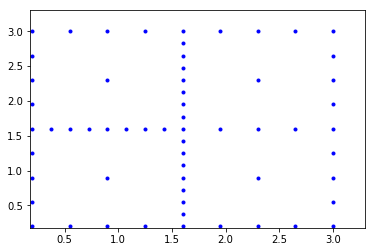

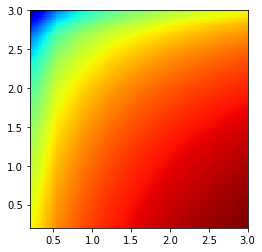

('this is iI:', 0)
('this is zz:', 0)
-66.6642333039
('this is zz:', 1)
-133.328466608
('this is zz:', 2)
-199.99269991
('this is zz:', 3)
-266.656933214
('this is zz:', 4)
-333.321166518
[-333.32116652]
('this is iI:', 1)
('this is zz:', 0)
-66.9946777984
('this is zz:', 1)
-133.989355597
('this is zz:', 2)
-200.984033396
('this is zz:', 3)
-267.978711195
('this is zz:', 4)
-334.973388993
[-334.97338899]
('this is iI:', 2)
('this is zz:', 0)
-66.5694583471
('this is zz:', 1)
-133.138916694
('this is zz:', 2)
-199.708375041
('this is zz:', 3)
-266.277833388
('this is zz:', 4)
-332.847291735
[-332.84729174]
('this is iI:', 3)
('this is zz:', 0)
-66.995339852
('this is zz:', 1)
-133.990679705
('this is zz:', 2)
-200.986019556
('this is zz:', 3)
-267.981359409
('this is zz:', 4)
-334.976699261
[-334.97669926]
('this is iI:', 4)
('this is zz:', 0)
-66.5690549226
('this is zz:', 1)
-133.138109845
('this is zz:', 2)
-199.707164768
('this is zz:', 3)
-266.27621969
('this is zz:', 4)
-332.8452

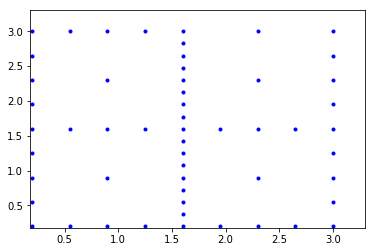

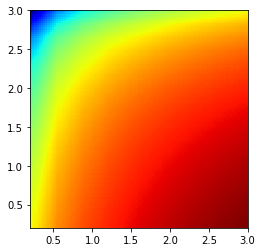

('this is iI:', 0)
('this is zz:', 0)
-66.6642333039
('this is zz:', 1)
-133.328466608
('this is zz:', 2)
-199.99269991
('this is zz:', 3)
-266.656933214
('this is zz:', 4)
-333.321166518
[-333.32116652]
('this is iI:', 1)
('this is zz:', 0)
-66.9946777984
('this is zz:', 1)
-133.989355597
('this is zz:', 2)
-200.984033396
('this is zz:', 3)
-267.978711195
('this is zz:', 4)
-334.973388993
[-334.97338899]
('this is iI:', 2)
('this is zz:', 0)
-66.5694583471
('this is zz:', 1)
-133.138916694
('this is zz:', 2)
-199.708375041
('this is zz:', 3)
-266.277833388
('this is zz:', 4)
-332.847291735
[-332.84729174]
('this is iI:', 3)
('this is zz:', 0)
-66.995339852
('this is zz:', 1)
-133.990679705
('this is zz:', 2)
-200.986019556
('this is zz:', 3)
-267.981359409
('this is zz:', 4)
-334.976699261
[-334.97669926]
('this is iI:', 4)
('this is zz:', 0)
-66.5690549226
('this is zz:', 1)
-133.138109845
('this is zz:', 2)
-199.707164768
('this is zz:', 3)
-266.27621969
('this is zz:', 4)
-332.8452

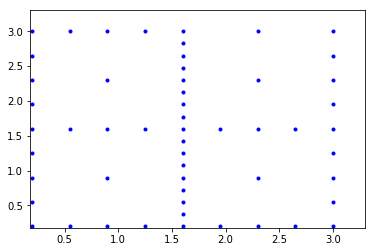

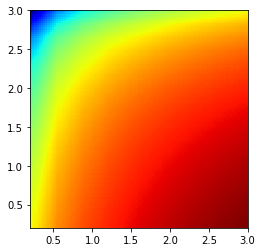

('this is iI:', 0)
('this is zz:', 0)
-66.6642333039
('this is zz:', 1)
-133.328466608
('this is zz:', 2)
-199.99269991
('this is zz:', 3)
-266.656933214
('this is zz:', 4)
-333.321166518
[-333.32116652]
('this is iI:', 1)
('this is zz:', 0)
-66.9946777984
('this is zz:', 1)
-133.989355597
('this is zz:', 2)
-200.984033396
('this is zz:', 3)
-267.978711195
('this is zz:', 4)
-334.973388993
[-334.97338899]
('this is iI:', 2)
('this is zz:', 0)
-66.5694583471
('this is zz:', 1)
-133.138916694
('this is zz:', 2)
-199.708375041
('this is zz:', 3)
-266.277833388
('this is zz:', 4)
-332.847291735
[-332.84729174]
('this is iI:', 3)
('this is zz:', 0)
-66.995339852
('this is zz:', 1)
-133.990679705
('this is zz:', 2)
-200.986019556
('this is zz:', 3)
-267.981359409
('this is zz:', 4)
-334.976699261
[-334.97669926]
('this is iI:', 4)
('this is zz:', 0)
-66.5690549226
('this is zz:', 1)
-133.138109845
('this is zz:', 2)
-199.707164768
('this is zz:', 3)
-266.27621969
('this is zz:', 4)
-332.8452

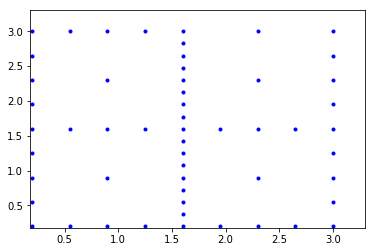

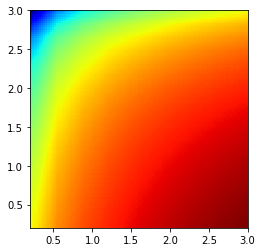

('this is iI:', 0)
('this is zz:', 0)
-66.6642333039
('this is zz:', 1)
-133.328466608
('this is zz:', 2)
-199.99269991
('this is zz:', 3)
-266.656933214
('this is zz:', 4)
-333.321166518
[-333.32116652]
('this is iI:', 1)
('this is zz:', 0)
-66.9946777984
('this is zz:', 1)
-133.989355597
('this is zz:', 2)
-200.984033396
('this is zz:', 3)
-267.978711195
('this is zz:', 4)
-334.973388993
[-334.97338899]
('this is iI:', 2)
('this is zz:', 0)
-66.5694583471
('this is zz:', 1)
-133.138916694
('this is zz:', 2)
-199.708375041
('this is zz:', 3)
-266.277833388
('this is zz:', 4)
-332.847291735
[-332.84729174]
('this is iI:', 3)
('this is zz:', 0)
-66.995339852
('this is zz:', 1)
-133.990679705
('this is zz:', 2)
-200.986019556
('this is zz:', 3)
-267.981359409
('this is zz:', 4)
-334.976699261
[-334.97669926]
('this is iI:', 4)
('this is zz:', 0)
-66.5690549226
('this is zz:', 1)
-133.138109845
('this is zz:', 2)
-199.707164768
('this is zz:', 3)
-266.27621969
('this is zz:', 4)
-332.8452

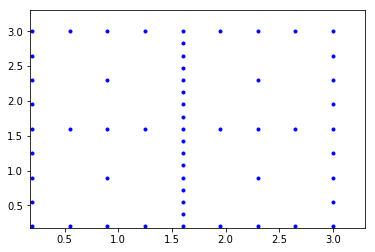

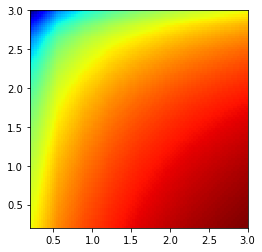

 
(' Computation of a growth model of dimension ', 2, ' finished after ', 3, ' steps')
 
 
 Errors are computed -- see errors.txt
 


In [39]:
#======================================================================
# Start with Value Function Iteration

# terminal value function
tempVal = [] ##new for zz stochastics

if (numstart==0): 
    print("VF INITIALIZATION:", numstart)
    
    for zz in range(num_states): ## added zz stochastics loop
        valnew=TasmanianSG.TasmanianSparseGrid()
        #valnew=interpol.sparse_grid(n_agents, iDepth)
        #valnew=sparse_grid(n_agents, iDepth)
        valnew=adap_sparse_grid(n_agents, iDepth, num_states,zz) # added zz stochastics
        valnew.write("valnew_1." + str(numstart) + ".txt") #write file to disk for restart
        tempVal.append(valnew) ##new for zz stochastics
        
# value function during iteration
else:
    valnew.read("valnew_1." + str(numstart) + ".txt")  #write file to disk for restart

tempValold = [] ##new for zz stochastics    
for zz in range(num_states): ## added zz stochastics loop
    valold=TasmanianSG.TasmanianSparseGrid()
    valold=tempVal[zz]
    tempValold.append(valold)

for i in range(numstart, numits):
    print("ITERATION NUMBER:", i+1)
    
    tempVal = [] ##new for zz stochastics 
    for zz in range(num_states): ## added zz stochastics loop
        valnew=TasmanianSG.TasmanianSparseGrid()
        #valnew=interpol_iter.sparse_grid_iter(n_agents, iDepth, valold)
        #valnew=sparse_grid_iter(n_agents, iDepth, valold)
        valnew=adap_sparse_grid_iter(n_agents, iDepth, tempValold,i,numits,num_states,zz)
        tempVal.append(valnew)
    
    tempValold = [] 
    
    for zz in range(num_states): ## added zz stochastics loop
        valold=TasmanianSG.TasmanianSparseGrid()
        valold=tempVal[zz]
        tempValold.append(valold)
        #valnew.write("valnew_1." + str(i+1) + ".txt")    
    
#======================================================================
print( "===============================================================")
print( " " )
print( " Computation of a growth model of dimension ", n_agents ," finished after ", numits, " steps")
print( " " )
print( "===============================================================")
#======================================================================

# compute errors   
avg_err=post.ls_error(n_agents, numstart, numits, No_samples)

#======================================================================
print( "===============================================================")
print( " ")
print( " Errors are computed -- see errors.txt")
print( " ")
print( "===============================================================")
#======================================================================